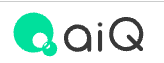

[disclaimer](../../disclaimer.txt/)

# Sales Prediction Using POS Csmr Goods

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import math
import itertools

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.linear_model import Lasso, LinearRegression 

from aiq_strategy_robot.data.data_accessor import DAL
from aiq_strategy_robot.data.FACTSET import load_factset_fundamental_estimates
from aiq_strategy_robot.predictors import ScikitLearnPredictor

if '../..' not in sys.path:
    sys.path.append('../..')
from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

## 1 Load POS Data

In [3]:
sdh = DAL()

# POS Data
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
alt_W_id = sdh.transform.raw(data_id=data_id_alt).variable_ids[0]

# sales(YoY) Data
data_id_funda = sc_common.register_fundamental(sdh)
funda_Q_id = sdh.transform.raw(data_id=data_id_funda).variable_ids[0]

# POS Share Ratio (Time Series)
share_ts = sc_common.read_pos_csmr_goods_plus_sales_share()

## 2 Data Preparation
- Each user needs to prepare the datasets below to run the notebook to the end.
- Consensus estimate of quarterly sales
- Realized quarterly sales

### 2.1 Consensus Sales Forecast
 Using Consensus Forecast as of the Closing Date
- TICKER
- fiscal_period_end_date: Fiscal quarter end date
- consensus_start_date: Date when the consensus becomes effective
- consensus_end_date: Date when the consensus is no longer valid
- consensus (FE_MEDIAN): Consensus (median of analyst forecasts)

In [4]:
USE_MY_CONS = True

cons = None
if USE_MY_CONS:
    #  Applicable When Using FactSet Data
    h1 = sdh.load('FACTSET', data_type='symbol_lookup',
                  ticker=list(map(lambda x: f"{x}-JP", sdh.extract_definition.loc[data_id_alt, 'tickers'])),
                  currency_code='JPY', exchange_code='TKS', pick_only_primary=True)
    comp = h1.retrieve(transformed=False)
    h2 = load_factset_fundamental_estimates(h1, symbols=list(comp['FSYM_ID']),
                                            package="BASIC", fields="SALES", freq=3)
    consensus = h2.retrieve()
    consensus = consensus.merge(comp, how='left', left_on='SYMBOL', right_on='FSYM_ID')
    consensus['TICKER'] = consensus['TICKER'].map(lambda x: x.split('-')[0])
    consensus = consensus.set_index(['TICKER', 'fiscal_period_end_date', 'consensus_start_date', 'consensus_end_date']).sort_index()
    consensus = consensus[consensus['FE_MEDIAN'] > 0]
    cons = consensus[consensus.index.get_level_values('consensus_start_date') <= consensus.index.get_level_values('fiscal_period_end_date')].groupby(
        ['TICKER', 'fiscal_period_end_date']).tail(1)[['FE_MEDIAN']].reset_index(['consensus_start_date', 'consensus_end_date']).rename(columns={'FE_MEDIAN': 'consensus'})
    
    #  Remove Unnecessary Columns
    cons = cons.drop(columns=['consensus_start_date', 'consensus_end_date'])
    cons.head()

/home/schiba/miniconda3/envs/sample/lib/python3.9/site-packages/snowflake/sqlalchemy/base.py:1068: SAWarning: The GenericFunction 'flatten' is already registered and is going to be overridden.
  functions.register_function("flatten", flatten)


### 2.2 Prepare realized quarterly sales data
Used for the following purposes:
- Converting consensus forecasts (absolute values, not YoY) to YoY
- Converting forecast results (log difference or difference) to absolute values

In [5]:
USE_MY_SALES = True

sales = None
if USE_MY_SALES:
    sales = pd.read_parquet('sales.parquet').sort_index()
    sales.index.names = ['TICKER', 'DATETIME']
    sales.head()

## 3. Selection of Preprocessing Parameters
- What is the lag in datasets that maximize the correlation between POS data and quarterly sales?
- We compute below such lags for each pair of (ticker, financial quarter).
- The allowed values are between -3 to 0 in integer. We do not consider smaller integer than -3 as bigger lags would cross POS data over quarterly earnings report timings.

In [6]:
lags = [-3, -2, -1, 0]
diffs = [True, False]

In [7]:
correlations = {}
pos_data = {}
for lag, diff in tqdm(itertools.product(lags, diffs), total=len(lags)*len(diffs)):
    
    alt_shift_id = alt_W_id
    if lag != 0:
        alt_shift_id = sdh.transform.shift(fields=alt_shift_id, periods=lag).variable_ids[0]
    
    alt_Q_shift_id = sdh.transform.resample_by(fields=alt_shift_id, label=funda_Q_id, func='mean').variable_ids[0]
    
    alt_id = sdh.transform.log_diff(fields=alt_Q_shift_id, periods=4).variable_ids
    sales_id = funda_Q_id

    if diff:
        alt_id = sdh.transform.diff(fields=alt_id, periods=1).variable_ids
        sales_id = sdh.transform.diff(fields=sales_id, periods=1).variable_ids

    
    data = pd.concat({
        'y': sdh.get_variables(sales_id).iloc[:, 0], 
        'X':sdh.get_variables(alt_id).iloc[:, 0]}, axis=1
    ).dropna()

    
    pos_data[lag, diff] = data
    for ticker, _ in tqdm(data.groupby('TICKER'), leave=False):
        for d in data.xs(ticker).expanding():
            if len(d.dropna()) < 10:
                continue
            mdl = sm.OLS(d['y'], sm.add_constant(d['X'].values), missing="drop").fit()
            correlations[ticker, d.index[-1], lag, diff] = { "t_val": mdl.tvalues['x1'] }
            
correlations = pd.DataFrame(correlations).T
correlations.index.names = ['TICKER', 'datetime', 'lag', 'diff1']
pos_data = pd.concat(pos_data)
pos_data.index.names = ['lag', 'diff', 'TICKER', 'DATETIME']

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

In [8]:
best_correlations = correlations.sort_values('t_val').groupby(['TICKER', 'datetime']).tail(1).reset_index(['lag', 'diff1']).sort_index()

## 4. Preprocessing POS data according to the optimal lags
- The following section computes the appropriately shifted POS data according to the optimal lags found in the previous section.

In [9]:
def set_data(dic, d):

    d = d.dropna().copy()
    if len(d) <= 20:
        return
    d.index.names = ['DATETIME']
    d['PRED_DATETIME'] = datetime
    d['TICKER'] = ticker
    d = d.reset_index().set_index(['PRED_DATETIME', 'TICKER', 'DATETIME'])
    dic.append(d)


dataset_with_consensus = []
dataset_without_consensus = []
for (ticker, until), setting in tqdm(best_correlations.iloc[:].iterrows(), total=len(best_correlations.iloc[:])):
    lag, diff1 = setting['lag'], setting['diff1']
    d = pos_data.xs(lag).xs(diff1).xs(ticker).loc[:until].copy()
    try:
        target = pos_data.xs(lag).xs(diff1).xs(ticker).loc[until:].iloc[1]
    except:
        continue
    datetime = target.name
    best_correlations.loc[(ticker, until), 'PRED_DATETIME'] = datetime
    
    d = pd.concat([d, target.to_frame().T])
    if (ticker, datetime) in cons.index:
        con = cons.xs(ticker)[['consensus']]
        con['pre'] = sales.xs(ticker).shift(4)['sales']
        con['y'] = np.log(con['consensus'] / con['pre'])
        if diff1:
            con['y'] = con['y'].diff()
        d['con_y'] = con['y']
        
        set_data(dataset_with_consensus, d)   
    else:
        set_data(dataset_without_consensus, d)


dfbest_correlations = best_correlations.reset_index().set_index(['TICKER', 'PRED_DATETIME'])
dfdataset_with_cons = pd.concat(dataset_with_consensus)
dfdataset_without_cons = pd.concat(dataset_without_consensus)

display(dfbest_correlations.tail())
display(dfdataset_with_cons.tail())
display(dfdataset_without_cons.tail())

  0%|          | 0/10890 [00:00<?, ?it/s]

datetime  lag  diff1     t_val
TICKER PRED_DATETIME                                 
9997   2023-06-30    2023-03-31   -3   True  2.348745
       2023-09-30    2023-06-30   -3   True  2.423474
       2023-12-31    2023-09-30   -3   True  2.452933
       2024-03-31    2023-12-31   -3   True  2.418634
       NaT           2024-03-31   -3   True  2.370913

y         X     con_y
PRED_DATETIME TICKER DATETIME                                
2024-03-31    9997   2022-12-31  0.015065 -0.845644  0.081961
                     2023-03-31  0.026520  0.629671  0.082671
                     2023-09-30  0.006300 -0.032195 -0.093056
                     2023-12-31 -0.000614  0.687694  0.006470
                     2024-03-31  0.026541 -0.367042 -0.030684

y         X
PRED_DATETIME TICKER DATETIME                      
2023-06-30    9997   2022-06-30 -0.081314  0.135409
                     2022-09-30  0.064297  0.528664
                     2022-12-31  0.015065 -0.845644
                     2023-03-31  0.026520  0.629671
                     2023-06-30 -0.038482 -0.384819

## 5. Prediction
- An OLS model is used for simplicity for predicting quarterly sales.

In [10]:
sdh = DAL()
predictor = ScikitLearnPredictor(sdh)

model = LinearRegression()

In [11]:
def formatting(dataset: pd.DataFrame, dfbest_corr: pd.DataFrame, dfpred):

    prediction = {}
    for (ticker, datetime), df in tqdm(dataset.groupby(['TICKER', 'PRED_DATETIME'])):
        train_x = df[df.index.get_level_values('DATETIME') < datetime]
        until = train_x.index.get_level_values('DATETIME').max()
    
        params = dfbest_corr.xs(ticker).xs(datetime)
        lag, diff1, t_val, until = params.lag, params.diff1, params.t_val, params['datetime']
    
        y_predict = dfpred.loc[ticker].loc[datetime]
        
        ys = pos_data.xs(lag).xs(ticker, level='TICKER')['y'].unstack('diff').loc[:datetime].copy()
        try:
            sales_pre = sales.xs(ticker).loc[:datetime, 'sales'].iloc[-5]
            sales_actual = sales.xs(ticker).xs(datetime)['sales'] # np.exp(ys).loc[datetime, False] * sales_pre
            sales_extrapolation = np.exp(ys[False].iloc[-2]) * sales_pre # 前期の実績成長率(YoY) * 前年同期の売上
        except:
            continue
        
        ys.loc[datetime, diff1] = y_predict.iloc[0]
        ys.loc[datetime, not diff1] = np.nan
        if diff1:
            ys.loc[datetime, False] = ys.loc[until, False] + ys.loc[datetime, True]
        sales_predict = np.exp(ys).loc[datetime, False] * sales_pre
        prediction[ticker, datetime] = {
            'actual': sales_actual, 
            'predict': sales_predict,
            "t_val": t_val,
            "extrapolation": sales_extrapolation
        }
    
    prediction = pd.DataFrame(prediction).T
    prediction.index.names = ['TICKER', 'datetime']

    return prediction

### 5.1 Predictions for tickers with Consensus Estimates
Linear Multiple Regression Using Consensus and POS Data
- Quality of predictions is evaluated using consensus estimates of quarterly sales. Can the predictions by POS data outplay concensus estimates?

In [12]:
sdh.set_raw_data(dfdataset_with_cons, alias='with_cons')
display(sdh.transform.variables)
y = sdh.transform.variables.index[0]
X = sdh.transform.variables.index[1:]

,variable_id,data_id,root_field,other_roots,step_001
variable_name,,,,,
WithCons_Y,1,1,y,-,raw()
WithCons_X,2,1,X,-,raw()
WithCons_Con_y,3,1,con_y,-,raw()


In [13]:
dfpred, _ = predictor.pred_ds('with_cons', X, y, model, ts_type='by_index', verbose=True)
prediction_with_consensus = formatting(dfdataset_with_cons, dfbest_correlations, dfpred)

Prediction running..: 100%|██████████| 107/107 [00:15<00:00,  6.95it/s]


,RMSE,MAE,rho,t-val,nsample
Stats.,0.09847,0.057267,0.628914,41.555077,2641.0


  0%|          | 0/2641 [00:00<?, ?it/s]

In [14]:
prediction_with_consensus['consensus'] = cons['consensus']
prediction_with_consensus['Predict'] = (prediction_with_consensus['predict'] - prediction_with_consensus['actual']) / prediction_with_consensus['actual']
prediction_with_consensus['Consensus'] = (prediction_with_consensus['consensus'] - prediction_with_consensus['actual']) / prediction_with_consensus['actual']
prediction_with_consensus['win'] = \
(prediction_with_consensus['predict'] - prediction_with_consensus['actual']).abs() < (prediction_with_consensus['consensus']  - prediction_with_consensus['actual']).abs()

In [15]:
prediction_with_consensus['win_rate_until'] = prediction_with_consensus['win'].sort_index().groupby('TICKER', group_keys=False).apply(lambda x: x.expanding().mean().shift(1))
pre_win = prediction_with_consensus[prediction_with_consensus['win_rate_until']>0.5].copy()
np.sqrt( (pre_win[['Predict', 'Consensus']]**2).mean() ).to_frame('RMSPE')

,RMSPE
Predict,0.111962
Consensus,0.149374


#### 5.1.1. The estimation errors of the model predictions are notablly smaller.

<AxesSubplot: title={'center': '0'}, xlabel='level_2'>

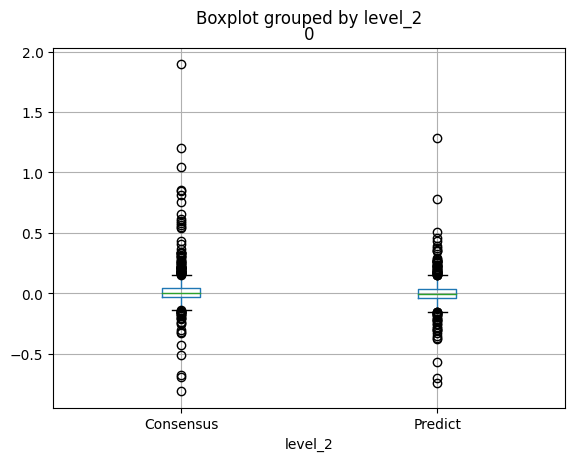

In [16]:
pre_win[['Predict', 'Consensus']].stack().reset_index(level=-1).boxplot(0, by='level_2')

In [17]:
matrix = ((pre_win['actual'] - pre_win['consensus']).map(np.sign) == (pre_win['predict'] - pre_win['consensus']).map(np.sign)).value_counts()
display(matrix.to_frame('direction_is_coincident'))
print(f'rate = {matrix[True] / sum(matrix)}')

,direction_is_coincident
True,559
False,309


rate = 0.6440092165898618


#### 5.1.2 POS assisted predictions forecast more accurately than concensus estimates

Text(0.5, 1.0, 'Consensus Forecast : YOY Increase\nPOS-Based Prediction : YOY Decrease')

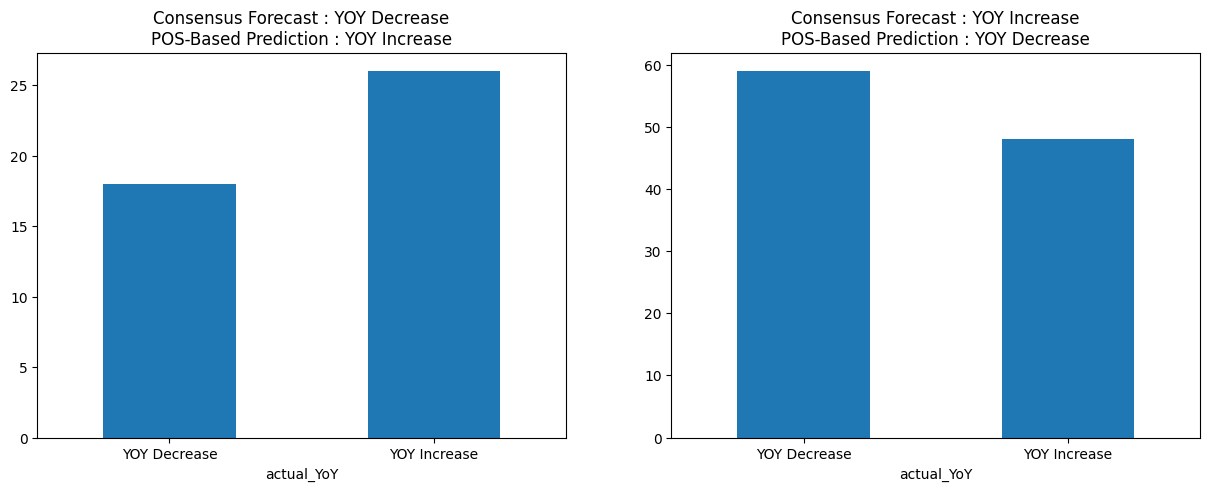

In [18]:
pre_win['actual_pre'] = sales.sort_index()['sales'].groupby('TICKER', group_keys=False).apply(lambda x: x.shift(4))
pre_win['actual_YoY'] = np.log(pre_win['actual']) - np.log(pre_win['actual_pre'])
pre_win['predict_YoY'] = np.log(pre_win['predict']) - np.log(pre_win['actual_pre'])
pre_win['consensus_YoY'] = np.log(pre_win['consensus']) - np.log(pre_win['actual_pre'])

_, axes = plt.subplots(1, 2, figsize=(15,5))
pre_win[(pre_win['consensus_YoY'] < 0) & (pre_win['predict_YoY'] > 0) ]['actual_YoY'].map(np.sign).map({1:'YOY Increase', -1:'YOY Decrease'}).value_counts().sort_index().plot.bar(ax=axes[0], rot=0)
axes[0].set_title('Consensus Forecast : YOY Decrease\nPOS-Based Prediction : YOY Increase')
pre_win[(pre_win['consensus_YoY'] > 0) & (pre_win['predict_YoY'] < 0) ]['actual_YoY'].map(np.sign).map({1:'YOY Increase', -1:'YOY Decrease'}).value_counts().sort_index().plot.bar(ax=axes[1], rot=0)
axes[1].set_title('Consensus Forecast : YOY Increase\nPOS-Based Prediction : YOY Decrease')

In [19]:
examples = pd.concat({'rate': prediction_with_consensus.groupby('TICKER')['win'].mean().sort_values(), 'count': prediction_with_consensus.groupby('TICKER')['win'].size()}, axis=1)
examples[examples['count']>=40].sort_values('rate').tail()

,rate,count
TICKER,,
3402,0.487805,41
4901,0.512195,41
8113,0.525000,40
4005,0.550000,40
4188,0.625000,40


#### 5.1.3 An example plot of prediction

Text(0, 0.5, 'YoY(logdiff)')

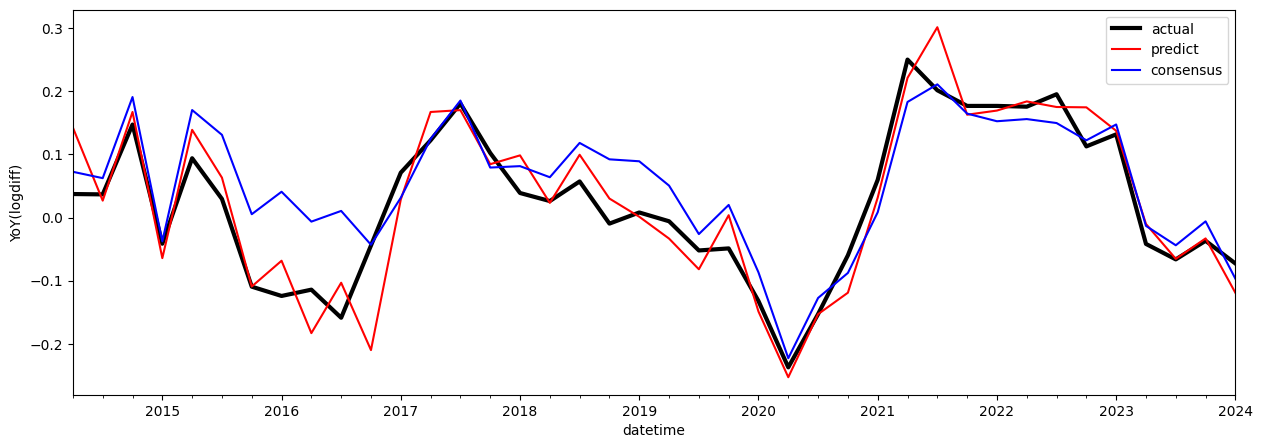

In [20]:
ticker = '4188'
sample = prediction_with_consensus.xs(ticker)[['actual', 'predict', 'consensus']].copy()
sample['pre'] = sales.xs(ticker).sort_index().shift(4)['sales']
sample[['pos', 'y']] = pos_data.xs(0).xs(False).xs(ticker)[['X', 'y']]

ax = (np.log(sample['actual']) - np.log(sample['pre'])).plot(color='black', linewidth=3, figsize=(15,5), label='actual')
(np.log(sample['predict']) - np.log(sample['pre'])).plot(color='red', ax=ax, label='predict')
(np.log(sample['consensus']) - np.log(sample['pre'])).plot(color='blue', ax=ax, label='consensus')
# sample['y'].plot(ax=ax, label='y', linestyle=':')
# sample['pos'].plot(ax=ax, label='POS', linestyle=':')
ax.legend()
plt.ylabel('YoY(logdiff)')

### 5.2 Prediction for Stocks without Consensus
We evaluate prediction quality separetely for tickers without any analyst consensus estimates.
This group of tickers often contain names with smaller presence in POS data and therefore we use POS sales share for screening them out.
We use year-on-year sales growth as the benchmark (naive prediction) against predictions.
- The estimation errors by POS data are smaller than the naive predictions
- YoY sales growth for the previous quarter is used as the benchmark.
- POS sales share of 5% is used to screen out tickers with confidence.

In [21]:
sdh.set_raw_data(dfdataset_without_cons, alias='without_cons')
display(sdh.transform.variables)
y = sdh.transform.variables.index[0]
X = sdh.transform.variables.index[1:]

,variable_id,data_id,root_field,other_roots,step_001
variable_name,,,,,
WithoutCons_Y,5,3,y,-,raw()
WithoutCons_X,6,3,X,-,raw()


In [22]:
dfpred, _ = predictor.pred_ds('without_cons', X, y, model, ts_type='by_index', verbose=True)
prediction_without_consensus = formatting(dfdataset_without_cons, dfbest_correlations, dfpred)

Prediction running..: 100%|██████████| 205/205 [00:24<00:00,  8.33it/s]


,RMSE,MAE,rho,t-val,nsample
Stats.,0.12802,0.068022,0.27868,18.559888,4093.0


  0%|          | 0/4093 [00:00<?, ?it/s]

In [23]:
prediction_without_consensus['Predict'] = (prediction_without_consensus['predict'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual']
prediction_without_consensus['Benchmark'] = (prediction_without_consensus['extrapolation'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual'] 
prediction_without_consensus['share'] = share_ts.groupby('seccode', group_keys=False)['mean'].apply(lambda x: x.shift(1)).reindex(prediction_without_consensus.index)
prediction_without_consensus['Benchmark'] = (prediction_without_consensus['extrapolation'] - prediction_without_consensus['actual']) / prediction_without_consensus['actual'] 

In [24]:
good = prediction_without_consensus[(prediction_without_consensus['share']>0.05)&(prediction_without_consensus['t_val']>0)].copy()
np.sqrt(((good[['Predict', 'Benchmark']])**2).mean()).to_frame('RMSPE')

,RMSPE
Predict,0.122343
Benchmark,0.143605
